In [1]:
import qiskit

In [1]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, QiskitRuntimeService

In [2]:
from qiskit import QuantumCircuit

In [3]:
import math

In [4]:
service = QiskitRuntimeService()

In [34]:
def half_adder(qc,first_qbit,first_classical_bit):

    #mesuare all qbits 0, 1 and 2
    qc.measure(first_qbit,first_classical_bit+0)
    qc.measure(first_qbit+1,first_classical_bit+1)
    qc.measure(first_qbit+2,first_classical_bit+2)

    #apply CNOT on qbits 1 and 0 with qbit 3 as control
    qc.cx(first_qbit+1,first_qbit+3)
    qc.cx(first_qbit,first_qbit+3)

    #apply CNOT on qbits 2 and 3 with qbit 4 as control
    qc.cx(first_qbit+2,first_qbit+4)
    qc.cx(first_qbit+3,first_qbit+4)

    #mesuare qbit 4 with contain the result of the sum of the qbits 0, 1 and 2
    qc.measure(first_qbit+4,first_classical_bit+3)

In [36]:
def carry_out(qc,first_qbit,first_classical_bit):
    #apply CCNOT on qbits 1 and 0 with qbit 5 as control
    qc.ccx(first_qbit+1,first_qbit,first_qbit+5)
    #apply CCNOT on qbits 2 and 3 with qbit 6 as control
    qc.ccx(first_qbit+2,first_qbit+3,first_qbit+6)

    #invert qbits 5 and 6
    qc.x(first_qbit+5)
    qc.x(first_qbit+6)

    #apply CcNOT on qbits 5 and 6 with qbit 7 as control
    qc.ccx(first_qbit+5,first_qbit+6,first_qbit+7)

    #reversible inversion of qbit 7
    qc.rx(math.pi,first_qbit+7)

    #measure qbit 7 with contain the carry out of the sum of the qbits 0, 1 and 2
    qc.measure(first_qbit+7,first_classical_bit+4)

In [37]:
def block_full_adder(value1,value2,carry_in,first_qbit,first_classical_bit):
    if value1 == 1:
        qc.x(first_qbit+1)
    if value2 == 1:
        qc.x(first_qbit+2)
    if carry_in == 1:
        qc.x(first_qbit)
    half_adder(qc,first_qbit,first_classical_bit)
    carry_out(qc,first_qbit,first_classical_bit)

In [38]:
#create quantum circuit with 7 qbits and 4 classical bits
qc = QuantumCircuit(16,10)
block_full_adder(1,1,1,0,0)
block_full_adder(1,1,0,7,5)

In [39]:
#without noise
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
#isa_observable = observable.apply_layout(isa_qc.layout)
with Session(backend=aer_sim) as session:
    sampler = Sampler()
    result = sampler.run([isa_qc]).result()

In [45]:
#with noise
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)
 
# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(mode=aer)
noiseresult = sampler.run([isa_qc]).result()

In [67]:
qc.cregs

[ClassicalRegister(5, 'c')]

In [40]:
result[0].data.c.get_counts()

{'1111111111': 1024}

In [41]:
results = list(result[0].data.c.get_counts().keys())[0]
carry_out = results[0]
sum = results[1]
carry_out, sum

('1', '1')

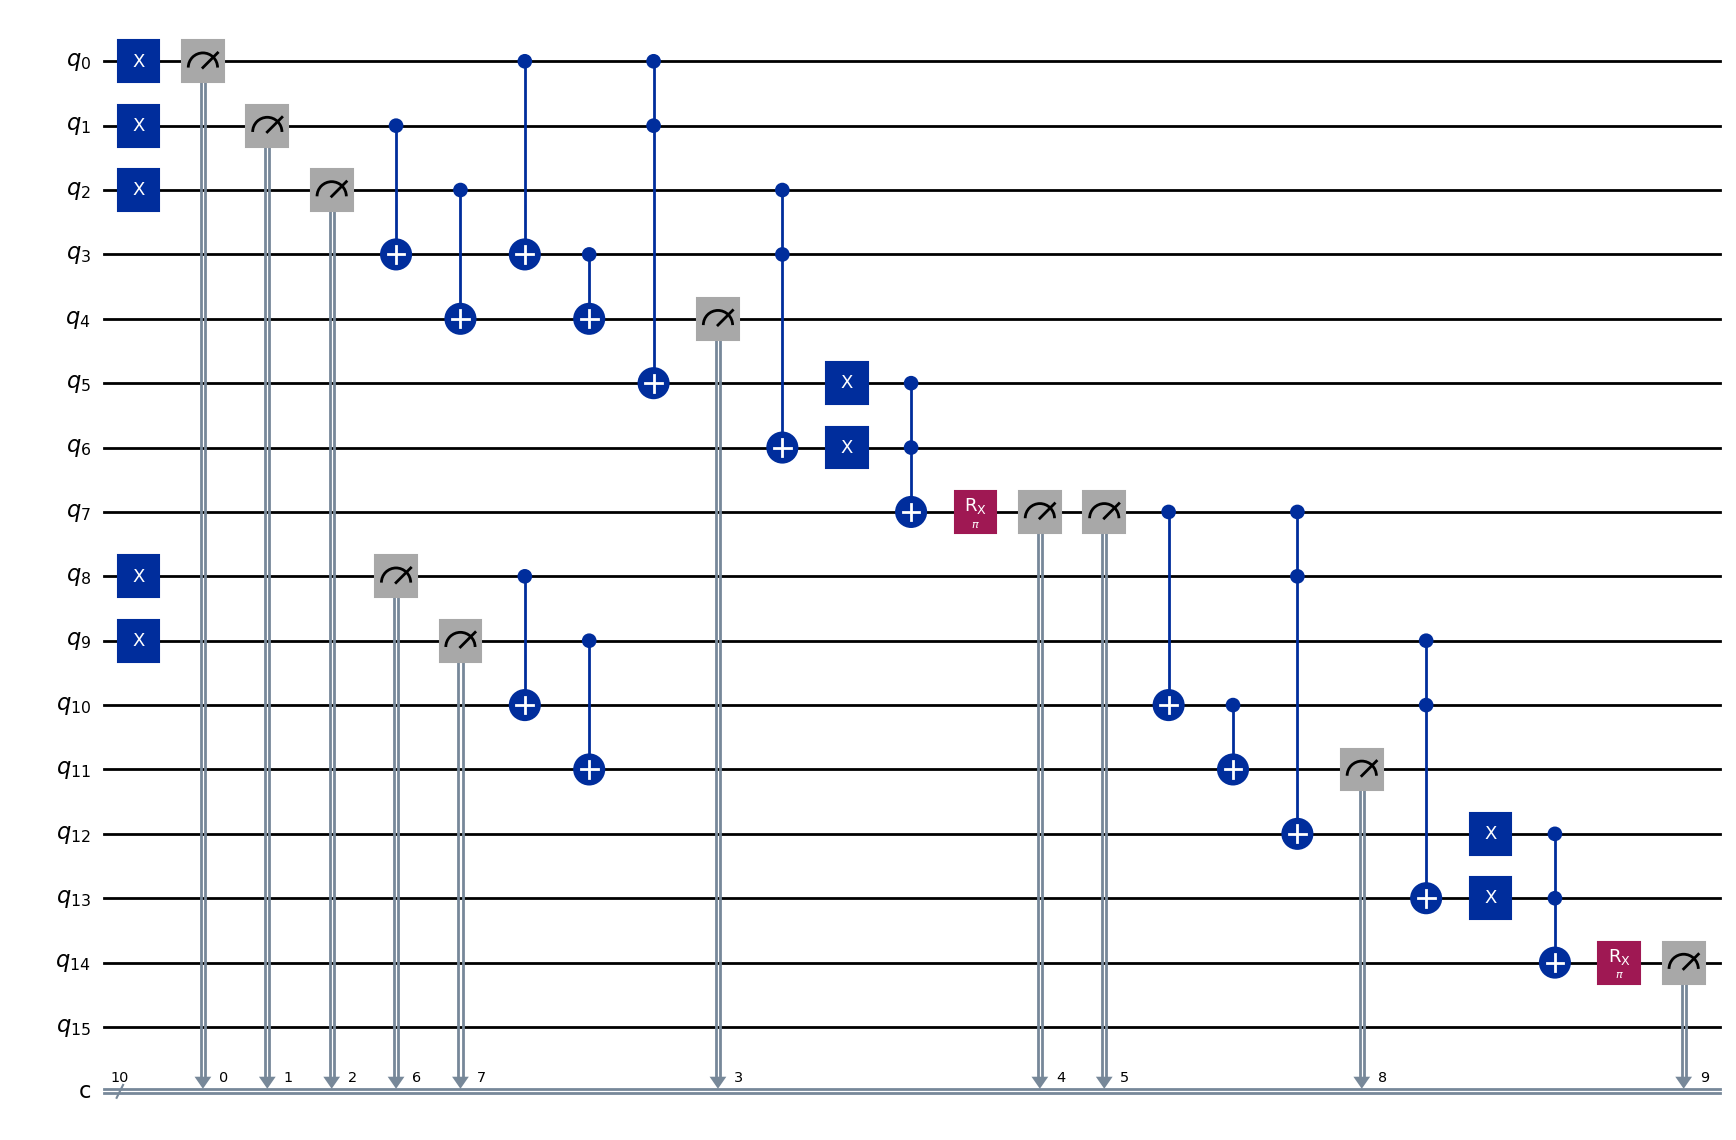

In [42]:
qc.draw(output='mpl',style='iqp')

In [43]:
noiseresult[0].data.c.get_counts()

{'10000': 117, '11000': 731, '01000': 153, '00000': 23}